In [1]:
import importlib

# Define the list of required Python packages
PACKAGES = ["casadi", "numpy", "matplotlib"]

# Check for each package and install if missing
for pkg in PACKAGES:
    try:
        importlib.import_module(pkg)
        print(f"{pkg} is already installed.")
    except ImportError:
        print(f"Installing {pkg}...")
        !pip install {pkg}

print("All dependencies are installed.")


casadi is already installed.
numpy is already installed.
matplotlib is already installed.
All dependencies are installed.


In [19]:
import numpy as np
from scipy.optimize import linprog
from scipy import linalg as lin
from math import *
from matplotlib import pyplot as plt
import casadi as ca


class Poly:
    @staticmethod
    def arg_cal(a: np.matrix):
        a_list = a.tolist()[0]
        cos_arg = a_list[0] / sqrt(a_list[0] ** 2 + a_list[1] ** 2)

        if float(a_list[1]) > 0:
            arg = acos(cos_arg)
        else:
            arg = -acos(cos_arg)

        return arg
    # 计算向量的辐角，用于给多边形的边排序

    def edges_sort(self, a: np.matrix, b: np.matrix):
        new_a, new_b = a.copy(), b.copy()
        if a.shape[0] < 2:
            return new_a
        else:
            last_exchange_index = 0
            sort_border = new_a.shape[0] - 1

            for i in range(0, new_a.shape[0] - 1):
                is_sorted = True
                for j in range(0, sort_border):
                    if self.arg_cal(new_a[j, :]) > self.arg_cal(new_a[j + 1, :]):
                        is_sorted = False
                        new_a[[j, j + 1], :] = new_a[[j + 1, j], :]
                        new_b[:, [j, j + 1]] = new_b[:, [j + 1, j]]
                        last_exchange_index = j  # 记住每一遍最后一个产生换序动作的序号，说明这之后的项无须排序，下一轮排序可以忽略
                sort_border = last_exchange_index
                if is_sorted:  # 如果走完一遍发现没有产生换序动作，那么说明已经排序完成，跳出循环
                    break

            return new_a, new_b
    # 冒泡排序算法，用于给多边形的边排序

    def vertex_cal(self, a: np.matrix, b: np.matrix):
        a_sort, b_sort = self.edges_sort(a, b)
        vertex = []

        for i in range(0, a_sort.shape[0] - 1):  # 按顺序两两求交点
            a_sol = a_sort[[i, i + 1], :].getA()
            b_sol = b_sort[:, [i, i + 1]].getA()[0]
            aug_mat = np.hstack((a_sort[[i, i + 1], :], b_sort[:, [i, i + 1]].T))
            if np.linalg.matrix_rank(a_sort[[i, i + 1], :]) == np.linalg.matrix_rank(aug_mat) and \
                    np.linalg.matrix_rank(aug_mat) == b_sort[:, [i, i + 1]].shape[1]:
                vertex.append(lin.solve(a_sol, b_sol))

        a_sol = a_sort[[0, -1], :].getA()  # 计算第一条边和最后一条边的交点
        b_sol = b_sort[:, [0, -1]].getA()[0]
        aug_mat = np.hstack((a_sort[[0, -1], :], b_sort[:, [0, -1]].T))
        if np.linalg.matrix_rank(a_sort[[0, -1], :]) == np.linalg.matrix_rank(aug_mat) and \
                np.linalg.matrix_rank(aug_mat) == b_sort[:, [0, -1]].shape[1]:
            vertex.append(lin.solve(a_sol, b_sol))

        return np.mat(vertex)
    # 根据已经排好的边的顺序，相邻边求交点，得出顶点，这种方法只适合凸多边形

    @staticmethod
    def support_fun(eta: np.matrix, a: np.matrix, b: np.matrix):
        bounds = [(None, None)] * eta.shape[1]
        res = linprog(-eta, A_ub=a, b_ub=b, bounds=bounds, method='revised simplex')

        return -res.fun
    # 计算凸两个多边形间的支撑函数

    def belong(self, v_a: np.matrix, v_b: np.matrix, u_a: np.matrix, u_b: np.matrix):
        res = True

        for i in range(0, u_a.shape[0]):
            res = res and (self.support_fun(u_a[i, :], v_a, v_b) <= float(u_b[0, i]))

        return res
    # 通过支撑函数判断一个凸多边形是否属于另一个凸多边形

    def plot(self, a: np.matrix, b: np.matrix, color):
        vertex = self.vertex_cal(a, b)

        vertex_list = vertex.T.tolist()

        plt.plot(vertex_list[0], vertex_list[1], color)
        plt.plot([vertex_list[0][0], vertex_list[0][-1]], [vertex_list[1][0], vertex_list[1][-1]], color)
    # 通过顶点画多边形

    @staticmethod
    def line_plot(a: np.matrix, b: np.matrix):
        for i in range(0, a.shape[0]):
            if float(a[i, 1]) == 0:
                x = []
                y = [-10 + 0.01 * i for i in range(0, int(20 / 0.01) + 1)]
                for _ in y:
                    x.append(float(b[:, i]/a[i, 0]))
                plt.plot(x, y)
            else:
                x = [-10 + 0.01 * i for i in range(0, int(20 / 0.01) + 1)]
                y = []
                for x_item in x:
                    y.append(float(-a[i, 0]/a[i, 1]*x_item+b[:, i]/a[i, 1]))
                plt.plot(x, y)

        plt.grid(True)
        plt.show()
    # 通过画出每条边的直线来画多边形

    @staticmethod
    def is_interior(point: np.matrix, a: np.matrix, b: np.matrix):
        b_bar = (a * point).T
        res = ((b_bar - b) <= 0).all()

        return res
    # 判断点是否在多边形内


class Remove(Poly):
    @staticmethod
    def all_zero(a: np.matrix, b: np.matrix):
        c = np.hstack((a, b.T))
        delete_line = []

        for i in range(0, c.shape[0]):
            if (c[i, :-1] == 0.).all():
                delete_line.append(i)

        c = np.delete(c, delete_line, 0)

        new_a = np.mat(np.delete(c, -1, 1))
        new_b = np.mat(c[:, -1].T)

        return new_a, new_b
    # 去除系数全为零的行

    @staticmethod
    def collinear(a: np.matrix, b: np.matrix):
        c = np.hstack((a, b.T))
        delete_line = []

        for i in range(0, c.shape[0]):
            for j in range(i + 1, c.shape[0]):
                test_mat = np.vstack((c[i, :], c[j, :]))
                if np.linalg.matrix_rank(test_mat) < 2:
                    delete_line.append(j)

        c = np.delete(c, delete_line, 0)

        new_a = np.mat(np.delete(c, -1, 1))
        new_b = np.mat(c[:, -1].T)

        return new_a, new_b
    # 去除一个线性不等式矩阵(A,b)中共线的边

    @staticmethod
    def redundant_term(a: np.matrix, b: np.matrix):
        delete_line = []

        for i in range(0, a.shape[0]):
            c = a[i, :]
            a_bar = np.mat(np.delete(a, i, 0))
            b_bar = np.mat(np.delete(b, i, 1))
            bounds = [(None, None)] * c.shape[1]
            res = linprog(-c, A_ub=a, b_ub=b, bounds=bounds, method='revised simplex')
            res_bar = linprog(-c, A_ub=a_bar, b_ub=b_bar, bounds=bounds, method='revised simplex')

            if 0.0001 > res.fun - res_bar.fun > -0.0001:
                delete_line.append(i)
            # 有它没它都一样的话，说明该项冗余

        new_a = np.mat(np.delete(a, delete_line, 0))
        new_b = np.mat(np.delete(b, delete_line, 1))
        # 下面这些是用于去除刚好通过顶点的线，它们满足上面的条件，但只与区域有一个交点，便是顶点

        return new_a, new_b
    # 除去不等式组(A,b)中的冗余项，即找不到一个x使得小于等于号等号成立，或只有一个顶点满足等号成立


class Minkowski(Remove):
    def poly_plus(self, a_1: np.matrix, b_1: np.matrix, a_2: np.matrix, b_2: np.matrix):
        if (a_1 == 0).all() and (b_1 == 0).all():
            return a_2, b_2
        elif (a_2 == 0).all() and (b_2 == 0).all():
            return a_1, b_1
        else:
            h_1 = np.mat(np.zeros((1, b_1.shape[1])))
            h_2 = np.mat(np.zeros((1, b_2.shape[1])))

            for i in range(0, a_1.shape[0]):
                h_1[0, i] = self.support_fun(a_1[i, :], a_2, b_2)

            for j in range(0, a_2.shape[0]):
                h_2[0, j] = self.support_fun(a_2[j, :], a_1, b_1)

            new_a = np.mat(np.vstack((a_1, a_2)))
            new_b = np.mat(np.hstack((b_1 + h_1, b_2 + h_2)))

            new_a, new_b = self.collinear(new_a, new_b)
            if new_a.shape[0] > 1:
                new_a, new_b = self.redundant_term(new_a, new_b)  # 去除冗余项
            # 两个多边形U = (A1,b1)，V = (A2,b2)的闵可夫斯基和是{f1_ix <= b1_i + hV(f1_i),f2_ix <= b2_i + hU(f2_i)}
            # h()是支撑函数
            return new_a, new_b
    # 两个凸多边形的闵可夫斯基和

    def poly_minus(self, a_1: np.matrix, b_1: np.matrix, a_2: np.matrix, b_2: np.matrix):
        if (a_2 == 0).all() and (b_2 == 0).all():
            return a_1, b_1
        else:
            h_1 = np.mat(np.zeros((1, b_1.shape[1])))

            for i in range(0, a_1.shape[0]):
                h_1[0, i] = self.support_fun(a_1[i, :], a_2, b_2)

            new_a = a_1
            new_b = b_1 - h_1
            new_a, new_b = self.collinear(new_a, new_b)  # 去除共线项
            if new_a.shape[0] > 1:
                new_a, new_b = self.redundant_term(new_a, new_b)  # 去除冗余项
            # 两个多边形U = (A1,b1)，V = (A2,b2)的闵可夫斯基和是{f1_ix <= b1_i - hV(f1_i)}
            # h()是支撑函数，计算完后还需去除冗余项
            return new_a, new_b
    # 两个凸多边形的闵可夫斯基差

    @staticmethod
    def point_poly_plus(point: np.matrix, a: np.matrix, b: np.matrix):
        h_point = []

        for i in range(0, a.shape[0]):
            h_point.append(float(a[i, :] * point))

        new_a = a
        new_b = b + np.mat(h_point)

        return new_a, new_b
    # 点和凸多边形的闵可夫斯基和


class TubeMPC(Minkowski):
    def __init__(self, x_ini: list, sys_para: dict, sys_cons: dict):
        self.x_ini = x_ini
        self.sys_para = sys_para
        self.sys_cons = sys_cons
        self.sys_para['P'], self.sys_para['K'] = self.lqr_p_k_cal(sys_para['A'], sys_para['B'], sys_para['Q'], sys_para['R'])
        # 用lqr方法求终端惩罚矩阵P和状态反馈矩阵K
        self.set = self.all_set_cal()
        # 计算所有用到的集合
        self.result = self.sys_sol()
        # 计算仿真结果
        self.t_list = [sys_para['d_t'] * num for num in range(0, int(sys_para['T'] / sys_para['d_t']))]
        # 产生时间序列用于画图

    def all_set_cal(self):
        A_K = self.sys_para['A'] - self.sys_para['B'] * self.sys_para['K']
        # 计算A_K
        A_Z, b_Z = self.z_cal(A_K, self.sys_cons['W']['A'], self.sys_cons['W']['b'])
        # 计算鲁棒正不变集
        A_D, b_D, A_X_Z, b_X_Z, U_KZ_inf, U_KZ_sup = self.domain_of_xf(self.sys_cons['X']['A'], self.sys_cons['X']['b'],
                                                                       self.sys_cons['U']['min'], self.sys_cons['U']['max'],
                                                                       A_Z, b_Z, self.sys_para['K'])
        # 用于计算X-Z和U-KZ，以及他们的交集作为求解Xf时的定义域
        A_Xf, b_Xf = self.xf_cal(A_D, b_D, A_K)
        # 计算终端区域Xf
        A_Xf_Z, b_Xf_Z = self.poly_plus(A_Xf, b_Xf, A_Z, b_Z)
        # 计算Xf + Z
        A_fea, b_fea = self.feasible_set(self.sys_para['A'], self.sys_para['B'], A_X_Z, b_X_Z, U_KZ_inf, U_KZ_sup, A_Xf, b_Xf,
                                         self.sys_para['n'])
        # 计算可行域
        A_fea_Z, b_fea_Z = self.poly_plus(A_fea, b_fea, A_Z, b_Z)
        # 计算可行域加Z

        all_set = {'Z': {'A': A_Z, 'b': b_Z},
                   'Xf': {'A': A_Xf, 'b': b_Xf},
                   'Xf+Z': {'A': A_Xf_Z, 'b': b_Xf_Z},
                   'fea': {'A': A_fea, 'b': b_fea},
                   'fea+Z': {'A': A_fea_Z, 'b': b_fea_Z},
                   'X-Z': {'inf': None, 'sup': float(b_X_Z)},
                   'U-KZ': {'inf': U_KZ_inf, 'sup': U_KZ_sup}}

        return all_set

    def z_cal(self, a: np.matrix, a_w: np.matrix, b_w: np.matrix):
        alpha = 0.2
        epsilon = 0.001
        s = 0
        a_w_s = a_w
        status = False

        a_fs = np.mat([[0, 0]])
        b_fs = np.mat([[0]])

        while not status:  # 这一步是寻找给定α后，使A^s*W属于α*W的s
            s = s + 1
            a_fs, b_fs = self.poly_plus(a_fs, b_fs, a_w_s, b_w)
            a_w_s = a_w * (np.linalg.inv(a)) ** s
            status = status or self.belong(a_w_s, b_w, a_w / alpha, b_w)

        max_support = []

        for i in range(0, a_w.shape[0]):  # 这一步是为了计算确定s后，使A^s*W属于α*W的最小的α
            max_support.append(self.support_fun(a_w[i, :], a_w_s, b_w) / float(b_w[0, i]))

        alpha = max(max_support)

        a_f_alpha_s = 1 / (1 - alpha) * a_fs  # 计算出F∞的逼近集合，这里下一步还可以继续逼近，但如果α够小，这个集合也足够了
        # 下面逼近的代码可以选用，可以注释掉不用，直接返回a_f_alpha_s和b_fs，逼近程度由epsilon决定
        n = 0
        ver = self.vertex_cal(a_f_alpha_s, b_fs)
        max_norm = max([float(ver[i, :]*ver[i, :].T) for i in range(0, ver.shape[0])])
        a_fn = np.mat([[0, 0]])
        b_fn = np.mat([[0]])
        a_w_n = a_w
        while max_norm > epsilon:
            n = n + 1
            ver = self.vertex_cal(a_f_alpha_s * (np.linalg.inv(a)) ** n, b_fs)
            max_norm = max([float(ver[i, :] * ver[i, :].T) for i in range(0, ver.shape[0])])
            a_fn, b_fn = self.poly_plus(a_fn, b_fn, a_w_n, b_w)
            a_w_n = a_w * (np.linalg.inv(a)) ** n

        a_z, b_z = self.poly_plus(a_f_alpha_s * (np.linalg.inv(a)) ** n, b_fs, a_fn, b_fn)

        return a_z, b_z
    # 计算正鲁棒不变集Z

    def domain_of_xf(self,
                     x_a: np.matrix,
                     x_b: np.matrix,
                     u_min,
                     u_max,
                     z_a: np.matrix,
                     z_b: np.matrix,
                     k: np.matrix
                     ):
        xf_x_a, xf_x_b = self.poly_minus(x_a, x_b, z_a, z_b)

        bounds = [(None, None)] * k.shape[1]
        res_max = linprog(-k, A_ub=z_a, b_ub=z_b, bounds=bounds, method='revised simplex')
        res_min = linprog(k, A_ub=z_a, b_ub=z_b, bounds=bounds, method='revised simplex')
        kz_max = -res_max.fun
        kz_min = res_min.fun

        xf_u_a = np.vstack((-k, k))
        xf_u_b = np.mat([[kz_min - u_min, u_max - kz_max]])  # 由于U是线段，因此计算出KZ的最大最小值进行闵可夫斯基差

        xf_a = np.mat(np.vstack((xf_x_a, xf_u_a)))
        xf_b = np.mat(np.hstack((xf_x_b, xf_u_b)))
        # 下面的返回值偷懒了，因为知道X-Z，U-KZ的形式是x，u的取值范围，所以只返回最值，正常情况应返回不等式组
        return xf_a, xf_b, xf_x_a, xf_x_b, u_min - kz_min, u_max - kz_max
    # 计算出满足x∈X-Z，Kx∈U-KZ的不等式组

    def xf_cal(self, d_a: np.matrix, d_b: np.matrix, a: np.matrix):
        t = 0
        a_cons, b_cons = d_a, d_b  # 初始状态

        while True:
            max_res = []

            for i in range(0, d_a.shape[0]):
                c = d_a[i, :] * (a ** (t + 1))
                bounds = [(None, None)] * d_a.shape[1]
                res = linprog(-c, A_ub=a_cons, b_ub=b_cons, bounds=bounds, method='revised simplex')
                max_res.append(-res.fun)
            # 检验Ot+1是否与Ot相等

            t = t + 1
            if ((np.mat(max_res) - d_b) <= 0).all():
                break  # 若相等则跳出循环

            a_cons = np.mat(np.vstack((a_cons, d_a * a ** t)))
            b_cons = np.mat(np.hstack((b_cons, d_b)))
            # 若不是则令Ot = Ot+1继续循环

        a_cons, b_cons = self.collinear(a_cons, b_cons)
        a_cons, b_cons = self.redundant_term(a_cons, b_cons)  # 得到结果后还需除去共线和冗余项
        # 计算方法是增加t，直到Ot == Ot+1，于是有O∞ = Ot
        return a_cons, b_cons
        # 计算终端约束区域Xf

    @staticmethod
    def mpc_m_build(a: np.matrix, n: int) -> np.matrix:

        m = np.mat([[1, 0], [0, 1]])
        a_i = np.mat([[1, 0], [0, 1]])

        for i in range(0, n):
            a_i = a_i * a
            m = np.vstack((m, a_i))

        return m
    # 求解Xk = M*xk + C*Uk中的M矩阵，便于之后求解可行域

    @staticmethod
    def mpc_c_build(a: np.matrix, b: np.matrix, n: int) -> np.matrix or int:

        if n == 0:
            c = 0
            return c

        else:
            row_delta = b
            row_delta_d = b
            c = np.vstack((np.mat(np.zeros((b.shape[0], b.shape[1]))), b))

            for i in range(0, n - 1):
                row_delta_d = a * row_delta_d
                row_delta = np.hstack((row_delta_d, row_delta))
                c = np.hstack((c, np.mat(np.zeros((c.shape[0], b.shape[1])))))
                c = np.vstack((c, row_delta))

            return c
    # 求解Xk = M*xk + C*Uk中的C矩阵，便于之后求解可行域

    @staticmethod
    def mpc_g_h_build(x_a: np.matrix, x_b: np.matrix, xf_a: np.matrix, xf_b: np.matrix, n: int):

        g = xf_a
        h = xf_b
        row_delta = x_a

        for i in range(0, n):
            row_delta = np.hstack((row_delta, np.mat(np.zeros((row_delta.shape[0], xf_a.shape[1])))))
            g = np.hstack((np.mat(np.zeros((g.shape[0], x_a.shape[1]))), g))
            g = np.vstack((row_delta, g))
            h = np.hstack((x_b, h))

        return g, h
    # 产生关于Xk的约束不等式组

    @staticmethod
    def uk_a_b_build(u_inf, u_sup, n: int):
        uk_a = np.mat(np.zeros((2 * n, n)))
        for i in range(0, n):
            uk_a[2 * i:2 * (i + 1), i] = np.mat([[1], [-1]])

        uk_b = np.mat([[u_sup, -u_inf] * n])

        return uk_a, uk_b
    # 产生关于Uk的约束不等式组

    def feasible_set(self,
                     a: np.matrix,
                     b: np.matrix,
                     x_a: np.matrix,
                     x_b: np.matrix,
                     u_inf,
                     u_sup,
                     xf_a: np.matrix,
                     xf_b: np.matrix,
                     n: int
                     ):
        m = self.mpc_m_build(a, n)
        c = self.mpc_c_build(a, b, n)
        g, h = self.mpc_g_h_build(x_a, x_b, xf_a, xf_b, n)
        uk_a, uk_b = self.uk_a_b_build(u_inf, u_sup, n)
        a_bar = np.vstack((np.hstack((g * m, g * c)),
                           np.hstack((np.mat(np.zeros((uk_a.shape[0], m.shape[1]))), uk_a))))
        b_bar = np.hstack((h, uk_b))
        # 这里先求出了M，C矩阵，于是知道了Xk = M*x + C*Uk，之后将约束条件转化为G*Xk <= h，再包含A_Uk*Uk <= b_Uk
        # 于是有
        # [G*M G*C ][x ]      [h   ]
        # [        ][  ]  <=  [    ]
        # [ 0  A_Uk][Uk]      [b_Uk]
        # a_bar, b_bar分别代表上面两个矩阵

        for k in range(0, b.shape[1] * n):  # 这里控制输入u是几维就是几乘n
            pos_a = []
            pos_b = []
            neg_a = []
            neg_b = []
            zero_a = []
            zero_b = []

            for i in range(0, a_bar.shape[0]):
                if a_bar[i, -1] > 0:
                    pos_a.append((a_bar[i, :-1] / a_bar[i, -1]).tolist()[0])
                    pos_b.append(b_bar[0, i] / a_bar[i, -1])
                elif a_bar[i, -1] < 0:
                    neg_a.append((a_bar[i, :-1] / (-a_bar[i, -1])).tolist()[0])
                    neg_b.append(b_bar[0, i] / (-a_bar[i, -1]))
                else:
                    zero_a.append(a_bar[i, :-1].tolist()[0])
                    zero_b.append(b_bar[0, i])

            pos_a = np.mat(pos_a)
            pos_b = np.mat([pos_b])
            neg_a = np.mat(neg_a)
            neg_b = np.mat([neg_b])
            zero_a = np.mat(zero_a)
            zero_b = np.mat([zero_b])

            new_a = []
            new_b = []

            for i in range(0, pos_a.shape[0]):
                for j in range(0, neg_a.shape[0]):
                    new_a.append((pos_a[i, :] + neg_a[j, :]).tolist()[0])
                    new_b.append(pos_b[0, i] + neg_b[0, j])

            for i in range(0, zero_a.shape[0]):
                new_a.append(zero_a[i, :].tolist()[0])
                new_b.append(zero_b[0, i])

            new_a = np.mat(new_a)
            new_b = np.mat([new_b])

            a_bar, b_bar = self.all_zero(new_a, new_b)
            a_bar, b_bar = self.collinear(a_bar, b_bar)
            a_bar, b_bar = self.redundant_term(a_bar, b_bar)

        # 以上是傅里叶-莫茨金消元法

        return a_bar, b_bar

    # 求解可行域，主要思路是构造满足条件的关于x，Uk的不等式组，通过Xk = M*x + C*Uk建立关系，之后利用傅里叶-莫茨金消元法
    # 将不等式组投影到x的平面上，便知道了使优化问题有解的x的取值范围

    @staticmethod
    def dm2arr(dm):
        return np.array(dm.full())
    # Ca sa di求解器类型转换

    @staticmethod
    def lqr_p_k_cal(a: np.matrix, b: np.matrix, q: np.matrix, r: np.matrix):
        p = np.mat(lin.solve_discrete_are(a, b, q, r))  # 求Riccati方程
        k = lin.inv(r + b.T * p * b) * b.T * p * a

        return p, k
    # 通过离散lqr计算出终端惩罚矩阵P和用来镇定实际状态和名义系统状态之差的矩阵K

    def sys_sol(self):
        z_num = self.set['Z']['A'].shape[0]

        xf_num = self.set['Xf']['A'].shape[0]

        x_1 = ca.SX.sym('x_1')
        x_2 = ca.SX.sym('x_2')
        states = ca.vertcat(x_1, x_2)  # 控制器中的状态
        n_states = states.numel()  # 行数

        u = ca.SX.sym('u')
        controls = ca.vertcat(u)  # 控制器中的输入
        n_controls = controls.numel()  # 行数

        X = ca.SX.sym('X', n_states, self.sys_para['n'] + 1)  # 控制器中的状态变量汇总起来
        U = ca.SX.sym('U', n_controls, self.sys_para['n'])  # 控制器中的输入变量汇总起来
        ini = ca.SX.sym('ini', n_states)  # 储存每次求优化时的初状态

        A = ca.SX(self.sys_para['A'])
        B = ca.SX(self.sys_para['B'])  # 状态矩阵
        omega = ca.SX(np.mat([[np.random.uniform(-0.1, 0.1)], [np.random.uniform(-0.1, 0.1)]]))  # 随机的干扰

        Q = ca.SX(self.sys_para['Q'])
        R = ca.SX(self.sys_para['R'])
        P = ca.SX(self.sys_para['P'])  # 三个权重矩阵

        K = ca.SX(self.sys_para['K'])  # 状态反馈矩阵

        Z_A = ca.SX(self.set['Z']['A'])  # 最小的鲁棒不变集
        Xf_A = ca.SX(self.set['Xf']['A'])  # 终端约束

        st_fun = A @ states + B @ controls + omega
        st_fun_nom = A @ states + B @ controls

        f = ca.Function('f', [states, controls], [st_fun])  # 对应状态方程中的f()
        f_nom = ca.Function('f_nom', [states, controls], [st_fun_nom])  # 对应状态方程中的f()

        cost_fn = 0

        g = Z_A @ (ini[:n_states] - X[:, 0])  # 初值约束

        for k in range(0, self.sys_para['n']):
            st = X[:, k]
            con = U[:, k]
            cost_fn = cost_fn + 1 / 2 * st.T @ Q @ st + 1 / 2 * con.T @ R @ con  # 构造代价函数

            st_next = X[:, k + 1]
            st_next_val = f_nom(st, con)
            g = ca.vertcat(g, st_next - st_next_val)  # 构造约束

        cost_fn = cost_fn + 1 / 2 * X[:, self.sys_para['n']].T @ P @ X[:, self.sys_para['n']]  # 还应加上终端代价函数

        ## obstacle avoidance
        obs_x = -5
        obs_y = 0
        obs_diam = 0.3
        rob_diam = 0.3
        for k in range(0, self.sys_para['n']):
            obs_constraints = ca.sqrt((X[0, k]-obs_x)**2+(X[1, k]-obs_y)**2)-(rob_diam/2.+obs_diam/2.)
            g = ca.vertcat(g, obs_constraints) # should be smaller als 0.0
        opt_variables = ca.vertcat( ca.reshape(U, -1, 1), ca.reshape(X, -1, 1))



        g = ca.vertcat(g, Xf_A @ X[:, self.sys_para['n']])  # 还有终端区域约束，输入约束加在bounds里

        opt_variables = ca.vertcat(X.reshape((-1, 1)), U.reshape((-1, 1)))  # 将x和u均视为优化问题的变量

        nlp_prob = {
            'f': cost_fn,
            'x': opt_variables,
            'g': g,
            'p': ini
        }

        opts = {
            'ipopt': {
                'max_iter': 2000,
                'print_level': 0,
                'acceptable_tol': 1e-8,
                'acceptable_obj_change_tol': 1e-6
            },
            'print_time': 0
        }  # 求解优化时的设置

        solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

        lbx = ca.DM.zeros((n_states * (self.sys_para['n'] + 1) + n_controls * self.sys_para['n'], 1))
        ubx = ca.DM.zeros((n_states * (self.sys_para['n'] + 1) + n_controls * self.sys_para['n'], 1))

        lbx[0: n_states * (self.sys_para['n'] + 1): n_states] = -ca.inf  # x_1 的下界为负无穷
        lbx[1: n_states * (self.sys_para['n'] + 1): n_states] = -ca.inf  # x_2 的下界为负无穷

        ubx[0: n_states * (self.sys_para['n'] + 1): n_states] = ca.inf  # x_1 的上界为正无穷
        ubx[1: n_states * (self.sys_para['n'] + 1): n_states] = self.set['X-Z']['sup']  # x_2 的上界

        lbx[n_states * (self.sys_para['n'] + 1):] = self.set['U-KZ']['inf']  # u 的下界
        ubx[n_states * (self.sys_para['n'] + 1):] = self.set['U-KZ']['sup']  # u 的上界

        lbg = ca.DM.zeros((n_states * self.sys_para['n'] + z_num + xf_num, 1))
        ubg = ca.DM.zeros((n_states * self.sys_para['n'] + z_num + xf_num, 1))

        for i in range(0, z_num):
            lbg[i] = -ca.inf
            ubg[i] = float(self.set['Z']['b'][0, i])  # x-x0始终在Z内

        for i in range(0, xf_num):
            lbg[z_num + n_states * self.sys_para['n'] + i] = -ca.inf
            ubg[z_num + n_states * self.sys_para['n'] + i] = float(self.set['Xf']['b'][0, i])  # x(N)在终端区域内

        args = {'lbg': lbg,
                'ubg': ubg,
                'lbx': lbx,
                'ubx': ubx
                }  # 将约束的值赋进去

        state_ini = ca.DM([self.x_ini[0], self.x_ini[1]])  # 系统初状态，要与解优化问题时的初值分清楚

        u0 = ca.DM.zeros((n_controls, self.sys_para['n']))
        X0 = ca.repmat(state_ini, 1, self.sys_para['n'] + 1)  # 求解优化过程中的初值

        cat_states = self.dm2arr(state_ini)  # 实际状态
        cat_nom_states = self.dm2arr(state_ini)  # 名义系统状态
        cat_controls = self.dm2arr(u0[:, 0])  # 实际控制量
        cat_controller_states = []  # 控制器内控制输入
        cat_controller_controls = []  # 控制器内状态

        for k in range(0, int(self.sys_para['T'] / self.sys_para['d_t'])):
            # start = time.time()

            args['p'] = ca.vertcat(state_ini)  # 每一时刻都把实际状态作为优化问题的参数传回去
            args['x0'] = ca.vertcat(ca.reshape(X0, n_states * (self.sys_para['n'] + 1), 1),
                                    ca.reshape(u0, n_controls * self.sys_para['n'], 1))
            # 用上一时刻的解的变换作为下一次求优化的初值，减少求优化的计算量，防止优化问题从可行域外开始解

            sol = solver(
                x0=args['x0'],
                lbx=args['lbx'],
                ubx=args['ubx'],
                lbg=args['lbg'],
                ubg=args['ubg'],
                p=args['p']
            )

            # end = time.time()

            # print(end - start)

            u = ca.reshape(sol['x'][n_states * (self.sys_para['n'] + 1):], n_controls, self.sys_para['n'])  # 控制器内预测的控制输入
            X0 = ca.reshape(sol['x'][: n_states * (self.sys_para['n'] + 1)], n_states, self.sys_para['n'] + 1)  # 控制器内预测的状态
            u_star = ca.DM(u[:, 0] - K @ (state_ini - X0[:, 0]))  # tube mpc控制律

            cat_nom_states = np.dstack((cat_nom_states, self.dm2arr(X0[:, 0])))  # 记录下控制器内预测状态的第一个值
            cat_controller_states.append(self.dm2arr(X0))  # 记录下控制器内预测状态
            cat_controller_controls.append(self.dm2arr(u))  # 记录下控制器内预测的输入
            cat_controls = np.vstack((cat_controls, self.dm2arr(u_star)))  # 记录下实际控制输入

            state_ini = ca.DM.full(f(state_ini, u_star))  # 更新状态
            cat_states = np.dstack((cat_states, state_ini))  # 记录下实际状态

            u0 = ca.horzcat(
                u[:, 1:],
                ca.reshape(u[:, -1], -1, 1)
            )

            X0 = ca.horzcat(X0[:, 1:], ca.reshape(X0[:, -1], -1, 1))  # 这两步是利用到上一步预测的一些结果到下一时刻求优化的初值中去

        res = {'real state 1': cat_states[0, :][0],
               'real state 2': cat_states[1, :][0],
               'nominal state 1': cat_nom_states[0, :][0],
               'nominal state 2': cat_nom_states[1, :][0],
               'real control': cat_controls.T[0],
               'predicted state': cat_controller_states,
               'predicted control': cat_controller_controls}  # 将结果打包

        return res
    # tube mpc在线优化

    def res_plot(self):
        self.plot(self.set['Z']['A'], self.set['Z']['b'], 'r')
        plt.grid(True)
        plt.show()
        self.plot(self.set['Xf']['A'], self.set['Xf']['b'], 'r')
        plt.grid(True)
        plt.show()

        # 以下被注释的代码用于观察控制器内预测的状态和输入，需要时可以查看
        # 这一段是画控制器内预测的控制输入
        '''t_controller_list = [0.1 * i for i in range(0, self.sys_para['n'])]
        for item in range(0, len(self.result['predicted control'])):
            plt.plot(t_controller_list, self.result['predicted control'][item][0])
            plt.show()'''
        # 这一段是画控制器内预测的状态
        '''for item in range(0, len(self.result['predicted state'])):
            plt.plot(self.result['predicted state'][item][0], self.result['predicted state'][item][1], 'r')'''

        plt.plot(self.result['real state 1'][:-1], self.result['real state 2'][:-1], '--')
        plt.plot(self.result['nominal state 1'][1:], self.result['nominal state 2'][1:])
        self.plot(self.set['Xf']['A'], self.set['Xf']['b'], 'b')
        self.plot(self.set['Xf+Z']['A'], self.set['Xf+Z']['b'], 'r')
        for item in range(0, len(self.result['nominal state 1']) - 1):
            A_nom_Z, b_nom_Z = self.point_poly_plus(np.mat([[self.result['nominal state 1'][item + 1]],
                                                            [self.result['nominal state 2'][item + 1]]]),
                                                    self.set['Z']['A'], self.set['Z']['b'])
            self.plot(A_nom_Z, b_nom_Z, 'g')
        plt.grid(True)
        plt.show()

        plt.plot(self.t_list, self.result['real control'][1:])
        plt.show()

        self.plot(self.set['fea']['A'], self.set['fea']['b'], 'r')
        self.plot(self.set['fea+Z']['A'], self.set['fea+Z']['b'], 'b')
        plt.grid(True)
        plt.show()
    # 用于画一些结果，可以根据需求自己改


if __name__ == "__main__":
    system_parameter = {'A': np.mat([[1, 1], [0, 1]]),
                        'B': np.mat([[0.5], [1]]),
                        'Q': np.mat([[1, 0], [0, 1]]),
                        'R': np.mat([[0.01]]),
                        'n': 9,      # 模型预测控制步数
                        'T': 0.9,    # 系统仿真总时间
                        'd_t': 0.1}  # 系统采样时间

    system_constraint = {'W': {'A': np.mat([[1, 0], [-1, 0], [0, 1], [0, -1]]),  # 干扰的约束
                               'b': np.mat([[0.1, 0.1, 0.1, 0.1]])},
                         'X': {'A': np.mat([[0, 1]]),                            # 状态的约束
                               'b': np.mat([[2]])},
                         'U': {'max': 1, 'min': -1}}                             # 控制输入的约束

    x_initial = [-5, -2]  # 系统初始状态

    tube_mpc = TubeMPC(x_initial, system_parameter, system_constraint)

    tube_mpc.res_plot()

C:\Users\mukul\AppData\Local\Temp\ipykernel_21332\3605917306.py:71: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(-eta, A_ub=a, b_ub=b, bounds=bounds, method='revised simplex')
C:\Users\mukul\AppData\Local\Temp\ipykernel_21332\3605917306.py:169: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(-c, A_ub=a, b_ub=b, bounds=bounds, method='revised simplex')
C:\Users\mukul\AppData\Local\Temp\ipykernel_21332\3605917306.py:170: DeprecationWarning: `method='revised simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res_bar = linprog(-c, A_ub=a_bar, b_ub=b_bar, bounds=bounds, method='revised simplex')
C:\Users\mukul\AppData\Local\Temp\ip

RuntimeError: .../casadi/core/function_internal.hpp:1257: Input 4 (lbg) has mismatching shape. Got 38-by-1. Allowed dimensions, in general, are:
 - The input dimension N-by-M (here 47-by-1)
 - A scalar, i.e. 1-by-1
 - M-by-N if N=1 or M=1 (i.e. a transposed vector)
 - N-by-M1 if K*M1=M for some K (argument repeated horizontally)
 - N-by-P*M, indicating evaluation with multiple arguments (P must be a multiple of 1 for consistency with previous inputs)

0.0, uend 
[[0.6, 0.785398], 
 [0.6, 0.785398], 
 [0.6, 0.515575], 
 [0.6, 0.170787], 
 [0.6, 0.785398], 
 [0.6, 0.785398], 
 [0.6, 0.785398], 
 [0.6, 0.785398], 
 [0.6, 0.169305], 
 [0.6, -0.106666], 
 [0.6, -0.239764], 
 [0.6, -0.352321], 
 [0.6, -0.465197], 
 [0.6, -0.563006], 
 [0.6, -0.618193], 
 [0.564235, -0.596505], 
 [0.302282, -0.434079], 
 [0.130827, -0.220572], 
 [-4.19729e-010, 1.66106e-024], 
 [-4.19729e-010, 1.66106e-024]]
0.2, uend 
[[0.6, 0.785398], 
 [0.6, 0.51599], 
 [0.6, 0.170171], 
 [0.6, 0.785398], 
 [0.6, 0.785398], 
 [0.6, 0.785398], 
 [0.6, 0.785398], 
 [0.6, 0.16578], 
 [0.6, -0.107552], 
 [0.6, -0.238954], 
 [0.6, -0.350305], 
 [0.6, -0.463545], 
 [0.6, -0.565736], 
 [0.6, -0.63242], 
 [0.6, -0.650698], 
 [0.351172, -0.533324], 
 [0.191392, -0.36409], 
 [0.0838713, -0.180971], 
 [-1.7692e-010, 3.99837e-025], 
 [-1.7692e-010, 3.99837e-025]]
0.4, uend 
[[0.6, 0.515978], 
 [0.6, 0.170189], 
 [0.6, 0.785398], 
 [0.6, 0.785398], 
 [0.6, 0.785398], 
 [0.6, 0.78539

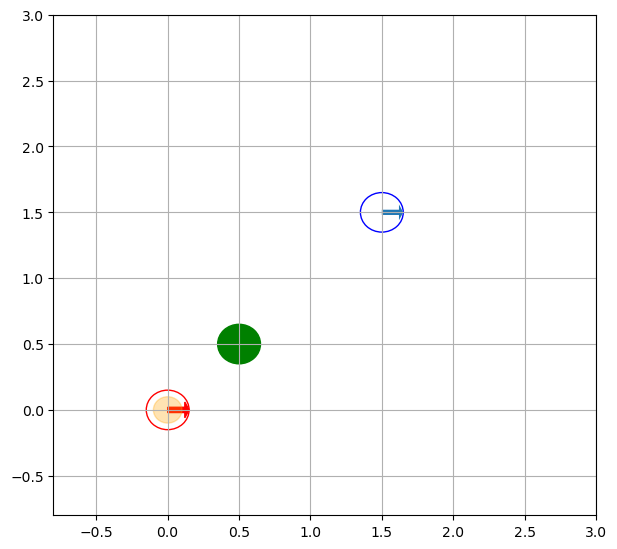

In [8]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import casadi as ca
import casadi.tools as ca_tools

import numpy as np
import time
from draw import Draw_MPC_Obstacle

def shift_movement(T, t0, x0, u_, f):
    # print('u come {}'.format(u_))
    #  u_temp = u_.T
    f_value = f(x0, u_[:, 0])
    # print('u0:{}\n'.format(u_[:, 0]))
    # print('{0}, {1}'.format(t0, f_value))
    st = x0 + T*f_value
    t = t0 + T
    # print('last x0 {}'.format(x0))
    # print('new st{}'.format(st))
    #print('u all {}'.format(u_.T))
    #print('u1 rest{}'.format(u_[:, 1:].T))
    u_end = ca.horzcat(u_[:, 1:], u_[:, -1])
    print('{0}, uend {1}'.format(t0, u_end.T))
    return t, st, u_end

if __name__ == '__main__':
    T = 0.2 # sampling time [s]
    N = 20 # prediction horizon
    rob_diam = 0.3 # [m]
    v_max = 0.6
    omega_max = np.pi/4.0

    states = ca_tools.struct_symSX([
        (
            ca_tools.entry('x'),
            ca_tools.entry('y'),
            ca_tools.entry('theta')
        )
    ])
    x, y, theta = states[...]
    n_states = states.size

    controls  = ca_tools.struct_symSX([
        (
            ca_tools.entry('v'),
            ca_tools.entry('omega')
        )
    ])
    v, omega = controls[...]
    n_controls = controls.size

    ## rhs
    rhs = ca_tools.struct_SX(states)
    rhs['x'] = v*ca.cos(theta)
    rhs['y'] = v*ca.sin(theta)
    rhs['theta'] = omega

    ## function
    f = ca.Function('f', [states, controls], [rhs], ['input_state', 'control_input'], ['rhs'])

    ## for MPC multi shooting
    optimizing_target = ca_tools.struct_symSX([
        (
            ca_tools.entry('U', repeat=N, struct=controls),
            ca_tools.entry('X', repeat=N+1, struct=states)
        )
    ])
    U, X, = optimizing_target[...] # data are stored in list [], notice that ',' cannot be missed

    current_parameters = ca_tools.struct_symSX([
        (
            ca_tools.entry('P', shape=n_states+n_states),
        )
    ])
    P, = current_parameters[...]

    ### define
    Q = np.array([[1.0, 0.0, 0.0],[0.0, 5.0, 0.0],[0.0, 0.0, .1]])
    R = np.array([[0.5, 0.0], [0.0, 0.05]])
    #### cost function
    obj = 0 #### cost
    #### constrains
    g = [] # equal constrains
    lbg = []
    ubg = []
    g.append(X[0]-P[:3]) # initial condition constraints
    for i in range(N):
        obj = obj + ca.mtimes([(X[i]-P[3:]).T, Q, X[i]-P[3:]]) + ca.mtimes([U[i].T, R, U[i]])
        x_next_ = f(X[i], U[i])*T + X[i]
        g.append(X[i+1] - x_next_)
    #### obstacle definition
    obs_x = 0.5
    obs_y = 0.5
    obs_diam = 0.3
    ##### add constraints to obstacle distance
    for i in range(N+1):
        g.append(ca.sqrt((X[i][0]-obs_x)**2+(X[i][1]-obs_y)**2)-(rob_diam/2.+obs_diam/2.))


    nlp_prob = {'f': obj, 'x': optimizing_target, 'p':current_parameters, 'g':ca.vertcat(*g)}
    opts_setting = {'ipopt.max_iter':100, 'ipopt.print_level':0, 'print_time':0, 'ipopt.acceptable_tol':1e-8, 'ipopt.acceptable_obj_change_tol':1e-6}

    solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts_setting)

    lbx = []
    ubx = []

    ## add constraints for equations
    for _ in range(N+1):
        lbg.append(0.0)
        ubg.append(0.0)
        lbg.append(0.0)
        ubg.append(0.0)
        lbg.append(0.0)
        ubg.append(0.0)
    for _ in range(N+1):
        lbg.append(0.0)
        ubg.append(np.inf)

    ## add constraints to control and states notice that for the N+1 th state
    for _ in range(N):
        lbx.append(-v_max)
        lbx.append(-omega_max)
        ubx.append(v_max)
        ubx.append(omega_max)
        lbx.append(-2.0)
        lbx.append(-2.0)
        lbx.append(-np.inf)
        ubx.append(2.0)
        ubx.append(2.0)
        ubx.append(np.inf)
    # for the N+1 state
    lbx.append(-2.0)
    lbx.append(-2.0)
    lbx.append(-np.inf)
    ubx.append(2.0)
    ubx.append(2.0)
    ubx.append(np.inf)

    # Simulation
    t0 = 0.0
    x0 = np.array([0.0, 0.0, 0.0]).reshape(-1, 1)# initial state
    x0_ = x0.copy()
    xs = np.array([1.5, 1.5, 0.0]).reshape(-1, 1) # final state
    u0 = np.array([0.0, 0.0]*N).reshape(-1, 2).T# np.ones((N, 2)) # controls
    ff_value = np.array([0.0, 0.0, 0.0]*(N+1)).reshape(-1, 3).T
    x_c = [] # contains for the history of the state
    u_c = []
    t_c = [t0] # for the time
    xx = []
    sim_time = 20.0

    ## start MPC
    mpciter = 0
    start_time = time.time()
    index_t = []
    ### inital test
    c_p = current_parameters(0)
    init_control = optimizing_target(0)
    # print(u0.shape) u0 should have (n_controls, N)
    while(np.linalg.norm(x0-xs)>1e-2 and mpciter-sim_time/T<0.0 ):
        ## set parameter
        # print('x0 {}'.format(x0))
        c_p['P'] = np.concatenate((x0, xs))
        init_control['X', lambda x:ca.horzcat(*x)] = ff_value # [:, 0:N+1]
        init_control['U', lambda x:ca.horzcat(*x)] = u0 # [:, 0:N]
        t_ = time.time()
        res = solver(x0=init_control, p=c_p, lbg=lbg, lbx=lbx, ubg=ubg, ubx=ubx)
        index_t.append(time.time()- t_)
        estimated_opt = res['x'].full() # the feedback is in the series [u0, x0, u1, x1, ...]
        ff_last_ = estimated_opt[-3:]
        temp_estimated = estimated_opt[:-3].reshape(-1, 5)
        u0 = temp_estimated[:, :2].T
        # print("run after {0}\n {1}".format(mpciter, u0.T))
        ff_value = temp_estimated[:, 2:].T
        ff_value = np.concatenate((ff_value, estimated_opt[-3:].reshape(3, 1)), axis=1) # add the last estimated result now is n_states * (N+1)
        # print("run after trajectory {}".format(ff_value.T))
        x_c.append(ff_value)
        u_c.append(u0[:, 0])
        t_c.append(t0)
        t0, x0, u0 = shift_movement(T, t0, x0, u0, f)
        x0 = ca.reshape(x0, -1, 1)
        #print('x0 {}'.format(x0))
        x0 = x0.full()
        xx.append(x0)
        mpciter = mpciter + 1

    print(mpciter)
    t_v = np.array(index_t)
    print(t_v.mean())
    print((time.time() - start_time)/(mpciter))
    draw_result = Draw_MPC_Obstacle(rob_diam=0.3, init_state=x0_, target_state=xs, robot_states=xx, obstacle=np.array([obs_x, obs_y, obs_diam/2.]), export_fig=False)